# 全結合層を用いたAutoEncoder

### AutoEncoderとは
入力データから同じデータを再現するためのニューラルネットワークのアーキテクチャ

**わかったこと**

- 畳み込み使ったときに比べて全然lossが下がってない(20倍くらい違う)
- epochを増やすとその分少しlossは下がるが、たかがしれてる
- 特徴が抽出できていないことがわかる
- 全結合層では位置情報や画像の構造などの特徴をうまく捉えられない

なぜ全結合層は特徴を抽出できないのか

→入力データの位置や構造を考慮せず、すべての入力特徴を同等に扱うため

In [1]:
import torch
from torch.utils.data import DataLoader
import torchvision
from torchvision import transforms
from torchvision.datasets import CIFAR10
import numpy as np
import matplotlib.pyplot as plt

In [2]:
def imshow(img):
    img = torchvision.utils.make_grid(img)   #グリッド上に並べて1枚の画像とする
    img = img / 2 + 0.5
    npimg = img.detach().numpy()   #新しいテンソルを用意
    print(npimg.shape)
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

In [8]:
def train(net, criterion, optimizer, epochs, trainloader, input_size):
    losses = []
    output_and_label = []
    
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    net = net.to(device)
    
    for epoch in range(1, epochs+1):
        print(f'epoch: {epoch},', end='')
        running_loss = 0.0
        for counter, (img, _) in enumerate(trainloader, 1):
            optimizer.zero_grad()
            img = img.reshape(-1, input_size)
            img.to(device)
            output = net(img)
            loss = criterion(output, img)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
        avg_loss = running_loss / counter
        losses.append(avg_loss)
        print('loss:', avg_loss)
        output_and_label.append((output, img))
    print('finished')
    return output_and_label, losses

In [9]:
class AutoEncoder2(torch.nn.Module):
    def __init__(self, enc, dec):
        super().__init__()
        self.enc = enc
        self.dec = dec
    
    def forward(self, x):
        x = self.enc(x)
        x = self.dec(x)
        return x

In [10]:
input_size = 3 * 32 * 32

encoder = torch.nn.Sequential(
    torch.nn.Linear(input_size, input_size // 4),
    torch.nn.ReLU(),
    torch.nn.Linear(input_size // 4, input_size // 12),
    torch.nn.ReLU(),
    torch.nn.Linear(input_size // 12, input_size // 24)
)

decoder = torch.nn.Sequential(
    torch.nn.Linear(input_size // 24, input_size // 12),
    torch.nn.ReLU(),
    torch.nn.Linear(input_size // 12, input_size // 4),
    torch.nn.ReLU(),
    torch.nn.Linear(input_size // 4, input_size),
    torch.nn.Tanh()
)

net = AutoEncoder2(encoder, decoder)

In [11]:
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
trainset = CIFAR10('./data', train=True, transform=transform, download=True)
testset = CIFAR10('./data', train=False, transform=transform, download=True)

batch_size = 50
trainloader = DataLoader(trainset, batch_size=batch_size, shuffle=True)
testloader = DataLoader(testset, batch_size=batch_size // 10, shuffle=False)

Files already downloaded and verified
Files already downloaded and verified


In [12]:
criterion = torch.nn.MSELoss()
optimizer = torch.optim.SGD(net.parameters(), lr=0.5)
EPOCHS = 100

output_and_label, losses = train(net, criterion, optimizer, EPOCHS, trainloader, input_size)

epoch: 1,loss: 0.2013843657299876
epoch: 2,loss: 0.1369295926168561
epoch: 3,loss: 0.11447228507697582
epoch: 4,loss: 0.09768699441850186
epoch: 5,loss: 0.0891778434664011
epoch: 6,loss: 0.085021511182189
epoch: 7,loss: 0.08023702747374772
epoch: 8,loss: 0.07548231741040945
epoch: 9,loss: 0.07159491966664791
epoch: 10,loss: 0.06891492968797684
epoch: 11,loss: 0.06714842126145959
epoch: 12,loss: 0.06555701503157615
epoch: 13,loss: 0.06400637719780207
epoch: 14,loss: 0.06267881962656975
epoch: 15,loss: 0.06134566024690866
epoch: 16,loss: 0.059912197649478915
epoch: 17,loss: 0.05851194870099425
epoch: 18,loss: 0.057220095153898004
epoch: 19,loss: 0.05594119853898883
epoch: 20,loss: 0.05488778490573168
epoch: 21,loss: 0.05408444626256823
epoch: 22,loss: 0.05338883947208524
epoch: 23,loss: 0.05276998694986105
epoch: 24,loss: 0.05225361379608512
epoch: 25,loss: 0.05170931942015886
epoch: 26,loss: 0.051269600182771685
epoch: 27,loss: 0.05082904321700334
epoch: 28,loss: 0.050403423104435206
ep

(3, 240, 274)


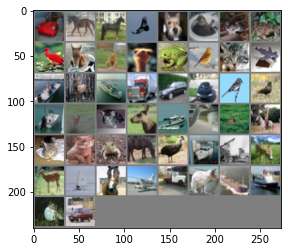

(3, 240, 274)


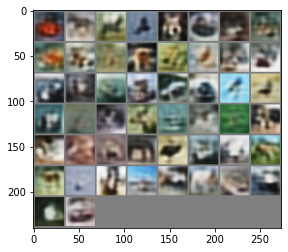

In [13]:
img, org = output_and_label[-1]
img = img.reshape(-1, 3, 32, 32)
org = org.reshape(-1, 3, 32, 32)
imshow(org)
imshow(img)

割とぼやけている

In [14]:
torch.save(net, '128epch100.pt')

In [15]:
encoder = torch.nn.Sequential(
    torch.nn.Linear(input_size, input_size // 2),
    torch.nn.ReLU(),
    torch.nn.Linear(input_size // 2, input_size // 4),
    torch.nn.ReLU(),
    torch.nn.Linear(input_size // 4, input_size // 8)
)

decoder = torch.nn.Sequential(
    torch.nn.Linear(input_size // 8, input_size // 4),
    torch.nn.ReLU(),
    torch.nn.Linear(input_size // 4, input_size // 2),
    torch.nn.ReLU(),
    torch.nn.Linear(input_size // 2, input_size),
    torch.nn.Tanh()
)

net2 = AutoEncoder2(encoder, decoder)

In [16]:
criterion = torch.nn.MSELoss()
optimizer = torch.optim.SGD(net2.parameters(), lr=0.5)
EPOCHS = 100

output_and_label, losses = train(net2, criterion, optimizer, EPOCHS, trainloader, input_size)

epoch: 1,loss: 0.1886225145533681
epoch: 2,loss: 0.12711424858123063
epoch: 3,loss: 0.10122448901087046
epoch: 4,loss: 0.08849985779076815
epoch: 5,loss: 0.08288420061022043
epoch: 6,loss: 0.07671087432280183
epoch: 7,loss: 0.07090071202069521
epoch: 8,loss: 0.06687599308788776
epoch: 9,loss: 0.06442441573739052
epoch: 10,loss: 0.061942856829613445
epoch: 11,loss: 0.05967809923365712
epoch: 12,loss: 0.057546290628612044
epoch: 13,loss: 0.05544721753895283
epoch: 14,loss: 0.05384785970300436
epoch: 15,loss: 0.05256046828255057
epoch: 16,loss: 0.05129615376517176
epoch: 17,loss: 0.05007352762296796
epoch: 18,loss: 0.04900486500188708
epoch: 19,loss: 0.04810202807933092
epoch: 20,loss: 0.04733410507068038
epoch: 21,loss: 0.046591649290174245
epoch: 22,loss: 0.045784610114991665
epoch: 23,loss: 0.04498130973055959
epoch: 24,loss: 0.04425373704731465
epoch: 25,loss: 0.04351272616162896
epoch: 26,loss: 0.04289862717688084
epoch: 27,loss: 0.04225765439122915
epoch: 28,loss: 0.0417358713708818

(3, 240, 274)


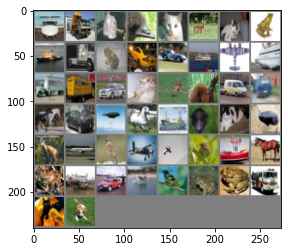

(3, 240, 274)


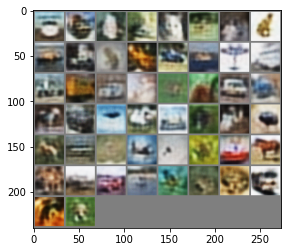

In [17]:
img, org = output_and_label[-1]
img = img.reshape(-1, 3, 32, 32)
org = org.reshape(-1, 3, 32, 32)
imshow(org)
imshow(img)

圧縮後384次元になるように組んだが、まだぼやけている

In [18]:
torch.save(net2, '385epch100.pt')